In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.measure import label, regionprops
from PIL import Image, ImageDraw
from ast import literal_eval
from tqdm.notebook import tqdm

import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout, Lambda,Conv2D, Conv2DTranspose, MaxPooling2D, MaxPooling2D, concatenate

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

In [2]:
import tensorflow as tf

In [3]:
# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512

#customization for running on laptop
# PATH =  os.getcwd() + "\\"
# TRAIN_PATH = PATH + "train\\"
# TEST_PATH = PATH + "test\\"

PATH = "C:/Users/Admin/Videos/WheatSSGC/"
TRAIN_PATH = 'C:/Users/Admin/Videos/WheatSSGC/train/'
TEST_PATH = 'C:/Users/Admin/Videos/WheatSSGC/test/'
#print(TEST_PATH)
len(TEST_PATH)
SC_FACTOR = int(1024 / IMG_WIDTH)

warnings.filterwarnings('ignore')
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [4]:
TRAIN_PATH = 'C:/Users/Admin/Videos/WheatSSGC/train'
print(TRAIN_PATH)
TEST_PATH = 'C:/Users/Admin/Videos/WheatSSGC/test'
len(TEST_PATH)

C:/Users/Admin/Videos/WheatSSGC/train


36

In [5]:
# PATH = "../input/global-wheat-detection/"
train_folder = os.path.join(PATH, "train")
print(train_folder)
test_folder = os.path.join(PATH, "test")

train_csv_path = os.path.join(PATH, "train.csv")

df = pd.read_csv(train_csv_path)
sample_sub = pd.read_csv(PATH + "sample_submission.csv")

df.head()

C:/Users/Admin/Videos/WheatSSGC/train


image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [6]:
train_ids = os.listdir(TRAIN_PATH)
test_ids = os.listdir(TEST_PATH)
print(train_ids)

#print(test_ids)

['00333207f.jpg', '005b0d8bb.jpg', '006a994f7.jpg', '00764ad5d.jpg', '00b5c6764.jpg', '00b5fefed.jpg', '00b70a919.jpg', '00e903abe.jpg', '00ea5e5ee.jpg', '010b216d4.jpg', '010c93b99.jpg', '010dbcc8f.jpg', '0114c88aa.jpg', '01189a3c3.jpg', '0126b7d11.jpg', '013669953.jpg', '01397a84c.jpg', '013fd7d80.jpg', '015939012.jpg', '0172359d2.jpg', '019d1c76a.jpg', '01e2c61d9.jpg', '01f37f1d3.jpg', '025ea7326.jpg', '02640d9da.jpg', '026b6f389.jpg', '027086635.jpg', '02992044c.jpg', '029c79463.jpg', '029e03e52.jpg', '02b6f199c.jpg', '02d662fa8.jpg', '02e02e347.jpg', '02f0fe2ca.jpg', '02fe8c28e.jpg', '030314634.jpg', '03173a1a5.jpg', '031ed396f.jpg', '034090252.jpg', '03448724b.jpg', '0352a6fff.jpg', '035bdc07a.jpg', '036cbd683.jpg', '037024e13.jpg', '037d96952.jpg', '038432e90.jpg', '03a177626.jpg', '03a242bd2.jpg', '03a988adf.jpg', '03ad2a35c.jpg', '03cae970d.jpg', '03d831c0d.jpg', '03dd40d7b.jpg', '041707ba8.jpg', '04201d2d6.jpg', '0424c00e4.jpg', '0429c9ff6.jpg', '0435654cd.jpg', '043a957ca.jp

In [7]:
def make_polygon(coords):
    xm, ym, w, h = coords
    xm, ym, w, h = xm / SC_FACTOR, ym / SC_FACTOR, w / SC_FACTOR, h / SC_FACTOR   # scale values if image was downsized
    return [(xm, ym), (xm, ym + h), (xm + w, ym + h), (xm + w, ym)]

masks = dict() # dictionnary containing all masks

for img_id, gp in tqdm(df.groupby("image_id")):
    gp['polygons'] = gp['bbox'].apply(eval).apply(lambda x: make_polygon(x))

    img = Image.new('L', (IMG_WIDTH, IMG_HEIGHT), 0)
    for pol in gp['polygons'].values:
        ImageDraw.Draw(img).polygon(pol, outline=1, fill=1)

    mask = np.array(img, dtype=np.uint8)
    masks[img_id] = mask

  0%|          | 0/3373 [00:00<?, ?it/s]

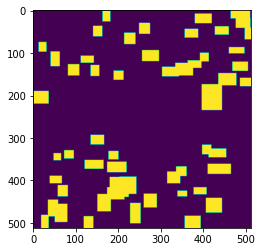

In [8]:
im = Image.fromarray(masks[list(masks.keys())[7]])
plt.imshow(im)

In [9]:
# Get and resize train images and masks

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids[:]), total=len(train_ids)):
    TRAIN_PATH = 'C:/Users/Admin/Videos/WheatSSGC/train/' 
    path = TRAIN_PATH + id_
    img = imread(path)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    id_clean = id_.split('.')[0]
    if id_clean in masks.keys():
        Y_train[n] = masks[id_clean][:, :, np.newaxis]

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
sizes_test = list()
print('Getting and resizing test images...')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    TEST_PATH = 'C:/Users/Admin/Videos/WheatSSGC/test/'
    path = TEST_PATH + id_
    print(path)
    img = imread(path)
    print(img)
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks... 


  0%|          | 0/3422 [00:00<?, ?it/s]

Getting and resizing test images...


  0%|          | 0/11 [00:00<?, ?it/s]

C:/Users/Admin/Videos/WheatSSGC/test/00ea5e5ee.jpg
[[[ 20  18  19]
  [ 19  18  16]
  [ 21  22  16]
  ...
  [155 191  91]
  [152 189  93]
  [149 189  92]]

 [[ 18  17  15]
  [ 17  18  13]
  [ 20  23  14]
  ...
  [153 189  91]
  [144 181  85]
  [139 176  81]]

 [[ 18  19  13]
  [ 18  21  12]
  [ 21  27  13]
  ...
  [141 175  78]
  [131 167  71]
  [122 159  64]]

 ...

 [[213 238 219]
  [207 232 211]
  [209 233 211]
  ...
  [141 172 104]
  [159 191 116]
  [141 172  94]]

 [[214 239 220]
  [210 235 214]
  [211 235 213]
  ...
  [116 147  79]
  [148 180 105]
  [150 181 103]]

 [[211 236 217]
  [215 238 218]
  [215 239 217]
  ...
  [ 95 126  58]
  [134 166  91]
  [148 179 103]]]
C:/Users/Admin/Videos/WheatSSGC/test/2fd875eaa.jpg
[[[ 28  20  17]
  [ 31  24  14]
  [ 35  28   9]
  ...
  [ 30  34  19]
  [ 35  33  21]
  [ 41  34  24]]

 [[ 25  18  12]
  [ 29  20  11]
  [ 33  26   7]
  ...
  [ 27  34  18]
  [ 31  31  19]
  [ 36  32  21]]

 [[ 23  14   7]
  [ 26  18   7]
  [ 31  24   5]
  ...
  [ 25

In [10]:
X_train.shape, Y_train.shape

((3422, 512, 512, 3), (3422, 512, 512, 1))

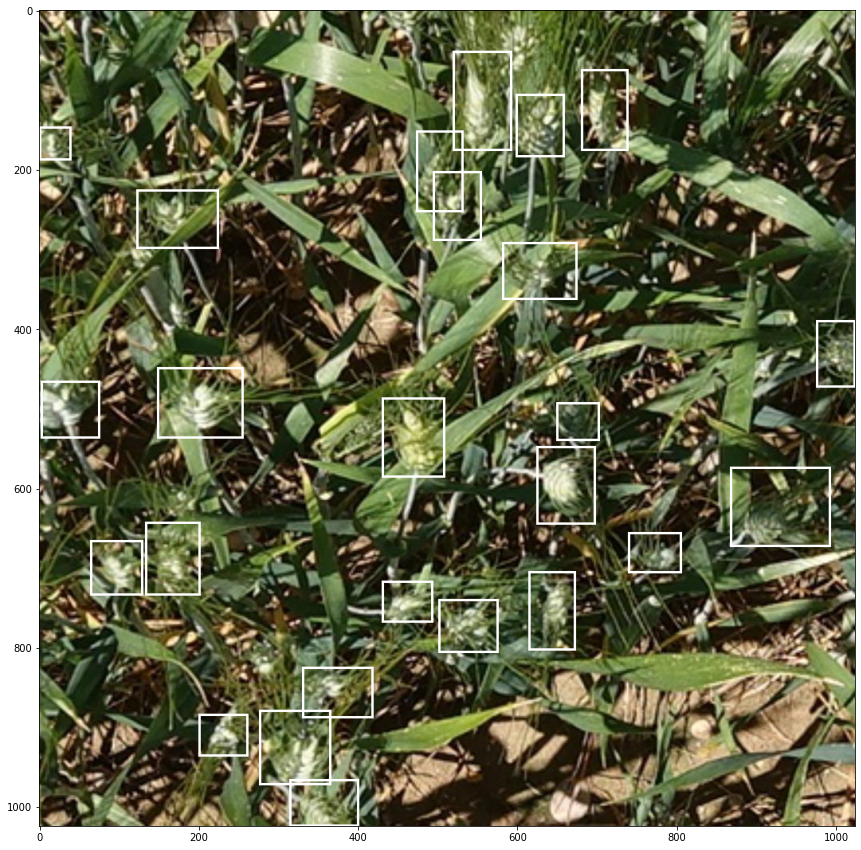

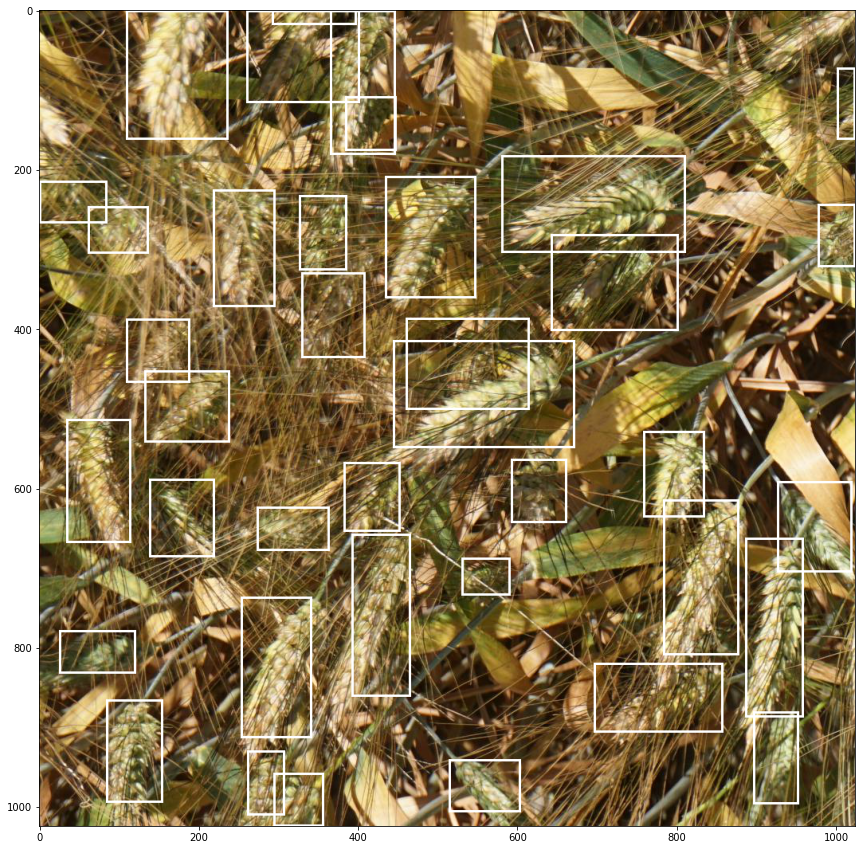

In [11]:
def show_images(images, num=2):
    
    images_to_show = np.random.choice(images, num)

    for image_id in images_to_show:

        image_path = os.path.join(train_folder, image_id + ".jpg")
        image = Image.open(image_path)

        # get all bboxes for given image in [xmin, ymin, width, height]
        bboxes = [literal_eval(box) for box in df[df['image_id'] == image_id]['bbox']]

        # visualize them
        draw = ImageDraw.Draw(image)
        for bbox in bboxes:    
            draw.rectangle([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]], width=3)

        plt.figure(figsize = (15,15))
        plt.imshow(image)
        plt.show()


unique_images = df['image_id'].unique()
show_images(unique_images)

In [12]:
#Credits to : https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63044

def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def competitionMetric2(true, pred):

    tresholds = [0.5 + (i * 0.05)  for i in range(5)]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

In [13]:
### Build U-Net model
    
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))
s = Lambda(lambda x: x / 255) (inputs)  # rescale inputs

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1])
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

p5 = Conv2DTranspose(16, (8, 8), strides=(16,16), padding = 'same') (c5)
u10 = concatenate([p5, c9], axis=3)
c10 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u10)
c10 = Dropout(0.1) (c10)
c10 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c10)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c10)


# instantiating the model in the strategy scope creates the model on the TPU

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[competitionMetric2])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [15]:
# Fit model
earlystop = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)

histry= model.fit(x=X_train,y=Y_train,
            validation_split=0.20,
            batch_size=16, 
            #steps_per_epoch=6*len(X_train)/8,
            epochs=2, 
            callbacks=[earlystop]
         )

Epoch 1/2
172/172 [==============================] - 3967s 23s/step - loss: 0.4631 - competitionMetric2: 0.0808 - val_loss: 0.4805 - val_competitionMetric2: 0.0160
Epoch 2/2
172/172 [==============================] - 3975s 23s/step - loss: 0.3680 - competitionMetric2: 0.2914 - val_loss: 0.3585 - val_competitionMetric2: 0.4284


In [16]:
print(model.summary)

<bound method Model.summary of <keras.engine.functional.Functional object at 0x000002153FF77970>>


In [29]:
from sklearn.metrics import accuracy_score
Y_pred = model.predict(X_test)
print(Y_pred)
#print('Done.\nAccuracy: %f' % accuracy_score(X_test,Y_pred))

[[[[0.18578902]
   [0.18150678]
   [0.1665864 ]
   ...
   [0.4288379 ]
   [0.48054028]
   [0.4216716 ]]

  [[0.17964074]
   [0.1521219 ]
   [0.1644082 ]
   ...
   [0.41949698]
   [0.48536992]
   [0.43400547]]

  [[0.16411299]
   [0.1403496 ]
   [0.13569754]
   ...
   [0.43345517]
   [0.4526064 ]
   [0.47023252]]

  ...

  [[0.34566504]
   [0.286914  ]
   [0.2549529 ]
   ...
   [0.41571426]
   [0.43258053]
   [0.4198097 ]]

  [[0.33711272]
   [0.36654997]
   [0.29668695]
   ...
   [0.4262374 ]
   [0.38449606]
   [0.39017665]]

  [[0.36430848]
   [0.31812143]
   [0.2872283 ]
   ...
   [0.4334784 ]
   [0.40070483]
   [0.43386003]]]


 [[[0.4687801 ]
   [0.5204988 ]
   [0.49778992]
   ...
   [0.24274728]
   [0.23661351]
   [0.33676612]]

  [[0.43942696]
   [0.61273706]
   [0.63826746]
   ...
   [0.19546923]
   [0.23835176]
   [0.22411492]]

  [[0.5683935 ]
   [0.6101964 ]
   [0.6925019 ]
   ...
   [0.15580088]
   [0.16164786]
   [0.24493241]]

  ...

  [[0.25768355]
   [0.17828912]
   [0.1

In [30]:
THRESH = 0.5

preds = model.predict(X_test)[:, :, :, 0]
masked_preds = preds > THRESH

In [31]:
preds.shape

(11, 512, 512)

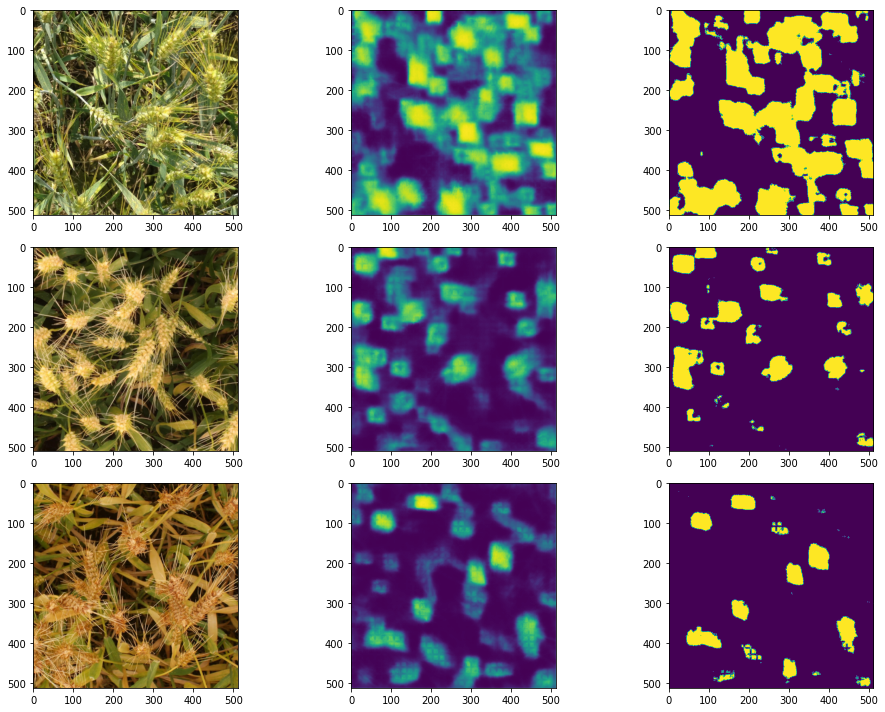

In [32]:
n_rows = 3
f, ax = plt.subplots(n_rows, 3, figsize=(14, 10))

for j, idx in enumerate([4,5,6]):
    for k, kind in enumerate(['original', 'pred', 'masked_pred']):
        if kind == 'original':
            img = X_test[idx]
        elif kind == 'pred':
            img = preds[idx]
        elif kind == 'masked_pred':
            masked_pred = preds[idx] > THRESH
            img = masked_pred
        ax[j, k].imshow(img)

plt.tight_layout()

In [33]:
def get_params_from_bbox(coords, scaling_factor=SC_FACTOR):
    xmin, ymin = coords[1] * scaling_factor, coords[0] * scaling_factor
    w = (coords[3] - coords[1]) * scaling_factor
    h = (coords[2] - coords[0]) * scaling_factor
    
    return xmin, ymin, w, h

In [34]:
# Allows to extract bounding boxes from binary masks
bboxes = list()

for j in range(masked_preds.shape[0]):
    label_j = label(masked_preds[j, :, :]) 
    props = regionprops(label_j,intensity_image=preds[j,:,:])   # that's were the job is done
    bboxes.append(props)

In [35]:
bboxes[0][0].bbox


(0, 60, 43, 104)

In [36]:
np.max(bboxes[0][0].intensity_image)

0.8501479

In [37]:
# Here we format the bboxes into the required format
output = dict()
significant_scores = list()
significant_bboxes = list()

for i in range(masked_preds.shape[0]):
    
    bboxes_processed = [get_params_from_bbox(bb.bbox, scaling_factor=SC_FACTOR) for bb in bboxes[i]]
    scores = [np.max(bb.intensity_image) for bb in bboxes[i]]
    
    bbareas = [bb.bbox_area for bb in bboxes[i]]
    
#     df_test = pd.DataFrame({'bboxe_processed':bboxes_processed,
#                             'scores':scores,
#                             'bbares':bbareas})
#     print(df_test.shape)
    
    significant_scores.append([score for score,area in zip(scores,bbareas) if ((score > 0.5) & (area > 100))])
    significant_bboxes.append([' '.join(map(str, bb_m)) for bb_m,score,area in zip(bboxes_processed,scores,bbareas) if ((score > 0.5) & (area > 100))])
    
    print("There are " + str(len(significant_scores[i])) + " Scores in "+ test_ids[i])
    print("There are " + str(len(significant_bboxes[i])) + " BBoxes in "+ test_ids[i])
    
    assert(len(significant_scores[i]) == len(significant_bboxes[i]))
    
    
    
    
    formated_boxes = [str(score) + ' '.join(map(str, bb_m)) for score,bb_m in zip(significant_scores[i],significant_bboxes[i])]
    
#     formated_boxes = formated_boxes[i > 100 for i in bbareas]
    
    output[str.split(test_ids[i],'.')[0]] = " ".join(formated_boxes)

There are 14 Scores in 00ea5e5ee.jpg
There are 14 BBoxes in 00ea5e5ee.jpg
There are 14 Scores in 2fd875eaa.jpg
There are 14 BBoxes in 2fd875eaa.jpg
There are 24 Scores in 348a992bb.jpg
There are 24 BBoxes in 348a992bb.jpg
There are 11 Scores in 51b3e36ab.jpg
There are 11 BBoxes in 51b3e36ab.jpg
There are 20 Scores in 51f1be19e.jpg
There are 20 BBoxes in 51f1be19e.jpg
There are 21 Scores in 53f253011.jpg
There are 21 BBoxes in 53f253011.jpg
There are 14 Scores in 796707dd7.jpg
There are 14 BBoxes in 796707dd7.jpg
There are 21 Scores in aac893a91.jpg
There are 21 BBoxes in aac893a91.jpg
There are 20 Scores in cb8d261a3.jpg
There are 20 BBoxes in cb8d261a3.jpg
There are 24 Scores in cc3532ff6.jpg
There are 24 BBoxes in cc3532ff6.jpg
There are 26 Scores in f5a1f0358.jpg
There are 26 BBoxes in f5a1f0358.jpg


In [38]:
sub  = pd.DataFrame()
sub['image_id'] = output.keys()
sub["PredictionString"] = output.values()
sub

image_id                                   PredictionString
0   00ea5e5ee  0.85014791 2 0   0   8 8   8 6 0.98813132 2   ...
1   2fd875eaa  0.98557880   0   3 4 8   3 4 2 0.99449613 9 4 ...
2   348a992bb  0.94707364 3 0   0   1 7 8   2 2 0 0.730744961...
3   51b3e36ab  0.968088870   0   1 0 6   1 6 0 0.98068525 5 2...
4   51f1be19e  0.95031680   0   1 5 8   2 9 2 0.97843423 7 4 ...
5   53f253011  0.915625931 6   0   2 2 4   1 4 0 0.64309934 8...
6   796707dd7  0.945518553 0 8   5 8   1 2 4   7 6 0.89192116...
7   aac893a91  0.89608993 4   0   1 0 8   8 4 0.9836231 5 6  ...
8   cb8d261a3  0.84183822 4 6   0   7 2   1 1 4 0.93501768 9 ...
9   cc3532ff6  0.82302030   0   8 0   1 2 0 0.63139362 0 6   ...
10  f5a1f0358  0.61500761 8 8   0   2 4   2 0 0.66484992 2 0 ...

In [39]:
sub = pd.merge(sample_sub[['image_id']],sub)
sub

image_id                                   PredictionString
0  aac893a91  0.89608993 4   0   1 0 8   8 4 0.9836231 5 6  ...
1  51f1be19e  0.95031680   0   1 5 8   2 9 2 0.97843423 7 4 ...
2  f5a1f0358  0.61500761 8 8   0   2 4   2 0 0.66484992 2 0 ...
3  796707dd7  0.945518553 0 8   5 8   1 2 4   7 6 0.89192116...
4  51b3e36ab  0.968088870   0   1 0 6   1 6 0 0.98068525 5 2...
5  348a992bb  0.94707364 3 0   0   1 7 8   2 2 0 0.730744961...
6  cc3532ff6  0.82302030   0   8 0   1 2 0 0.63139362 0 6   ...
7  2fd875eaa  0.98557880   0   3 4 8   3 4 2 0.99449613 9 4 ...
8  cb8d261a3  0.84183822 4 6   0   7 2   1 1 4 0.93501768 9 ...
9  53f253011  0.915625931 6   0   2 2 4   1 4 0 0.64309934 8...

In [40]:
sub.to_csv('submission.csv', index=False)